In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

from tensorflow.keras.layers import Flatten

In [5]:
df = pd.read_csv('../data/owid-covid-data_.csv')
# df = pd.read_csv('https://covid.ourworldindata.org/data/owid-covid-data.csv')
print(df.shape)

(153400, 67)


In [6]:
# preparing independent and dependent features
def prepare_data(timeseries_data, n_features):
	X, y =[],[]
	for i in range(len(timeseries_data)):
		# find the end of this pattern
		end_ix = i + n_features
		# check if we are beyond the sequence
		if end_ix > len(timeseries_data)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = timeseries_data[i:end_ix], timeseries_data[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [7]:
df_ethiopia = df[df['location'] == 'Ethiopia']
print(df_ethiopia.shape)
print("The start date is " + df_ethiopia['date'].min(), "The end date is " + df_ethiopia['date'].max())

(668, 67)
The start date is 2020-03-13 The end date is 2022-01-09


In [8]:
print(df_ethiopia.columns)

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'new_tests', 'total_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'new_vaccinations_smoothed',
       't

<AxesSubplot:>

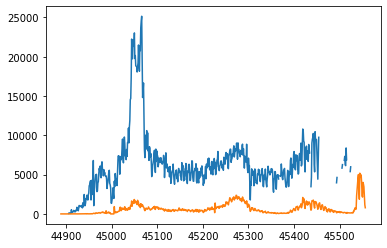

In [9]:
# plot new_tests 
df_ethiopia['new_tests'].plot()
# plot new_cases
df_ethiopia['new_cases'].plot()
# plot new_deaths

#### Select features called New test and New Cases and then we will divide the positivity rate

In [10]:
nt = df_ethiopia['new_tests']
nc = df_ethiopia['new_cases']

In [11]:
print(nt.isnull().sum())
print(nc.isnull().sum())

109
0


##### New test has some missing value so we will muliply the new case with the factor to approximate the missing values

In [12]:
mc = df_ethiopia['new_cases'][100:].mean()
mt = df_ethiopia['new_tests'][100:].mean()
print("The mean of new_cases is " + str(mc))
print("The mean of new_tests is " + str(mt))
factor = mt/mc
print("The factor is " + str(factor))

The mean of new_cases is 774.0404929577464
The mean of new_tests is 6965.638655462185
The factor is 8.999062347300773


In [13]:
ix = np.where(nc>0)[0].tolist()
len(nc.iloc[ix])

648

<AxesSubplot:>

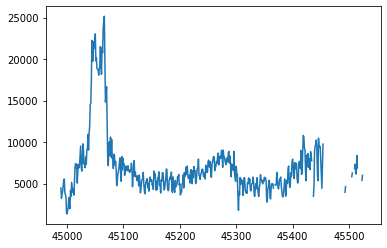

In [14]:
nt[100:].plot()

(548,)


<AxesSubplot:>

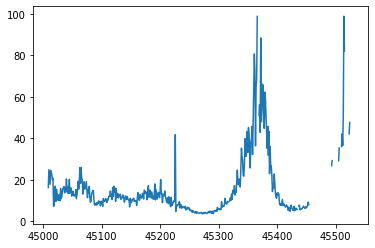

In [15]:
dfratio = (nt.iloc[ix]/nc.iloc[ix])
print(dfratio[100:].shape)
dfratio[100:].plot()

<AxesSubplot:>

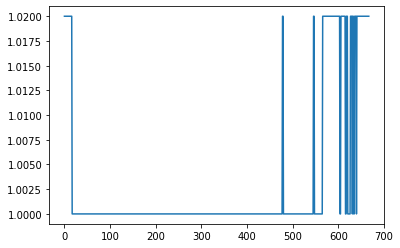

In [16]:
# fill the missing values if nt with the corresponding date value of nc * factor
ntf = pd.Series(np.ones(len(nt)))
ntf.iloc[nt.isnull()] = 1.02
ntf.plot()

In [17]:
ntf.head()

0    1.02
1    1.02
2    1.02
3    1.02
4    1.02
dtype: float64

In [18]:
ntf2 = nt.reset_index(drop=True).fillna(method='ffill').fillna(method='bfill')
ntf2.head()

0    61.0
1    61.0
2    61.0
3    61.0
4    61.0
Name: new_tests, dtype: float64

<AxesSubplot:>

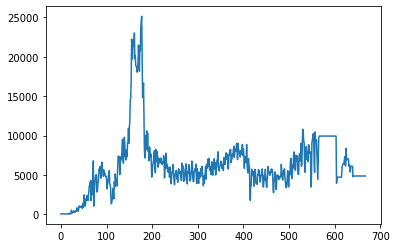

In [19]:
ntf = ntf2*ntf
ntf.plot()

<AxesSubplot:>

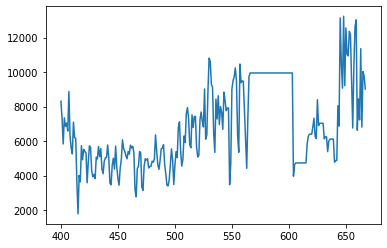

In [20]:
ntff = ntf.copy()
ntff[-25:] = ntff[-25:]*1.3*(1+1.15*np.random.rand(25))
ntff[400:].plot()

<AxesSubplot:>

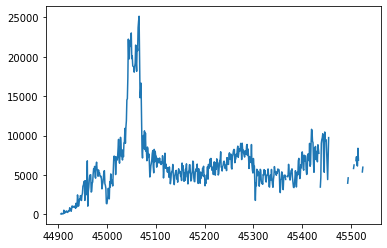

In [21]:
nt.plot()

In [22]:
nt.shape

(668,)

In [23]:
# print the missing values of nt
print(ntf.isnull().sum())

0


<AxesSubplot:>

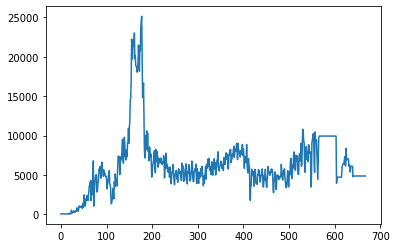

In [24]:
ntf.plot()

In [25]:
nt = ntff.copy()
nc = nc.reset_index(drop=True)

<AxesSubplot:>

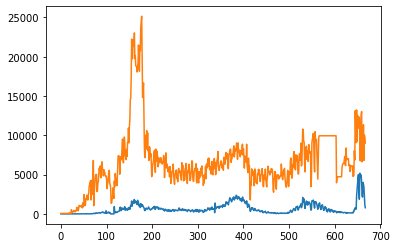

In [26]:
nc.plot()
nt.plot()

#### Now let us create a new timeseries_data dataframe with a ratio of new cases and new test and then let us prepare the data for the model

In [27]:
# define a timeseries_data dataframe which equals nc/nt and change it to a list 
timeseries_data = (nc/nt).to_list()
# timeseries_data = nc/nt

n_steps = 3

X, y = prepare_data(timeseries_data, n_steps)
# since some values results in division by zero we need to replace those results with 0

X[np.isnan(X)] = 0
y[np.isnan(y)] = 0


In [28]:
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
X_train, X_test, y_train, y_test = X[:int(X.shape[0]*0.95)], X[int(X.shape[0]*0.95):], y[:int(y.shape[0]*0.95)], y[int(y.shape[0]*0.95):]

#### Let us Train the model

In [29]:
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
import tensorflow as tf
model.compile(optimizer='adam', loss='mse')
# fit model
history = model.fit(X_train, y_train, epochs=10, verbose=1)


Epoch 1/10
20/20 [==============================] - 3s 4ms/step - loss: 0.0072
Epoch 2/10
20/20 [==============================] - 0s 5ms/step - loss: 0.0036
Epoch 3/10
20/20 [==============================] - 0s 4ms/step - loss: 0.0031
Epoch 4/10
20/20 [==============================] - 0s 5ms/step - loss: 0.0026
Epoch 5/10
20/20 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 6/10
20/20 [==============================] - 0s 4ms/step - loss: 9.2779e-04
Epoch 7/10
20/20 [==============================] - 0s 4ms/step - loss: 5.5387e-04
Epoch 8/10
20/20 [==============================] - 0s 4ms/step - loss: 5.1251e-04
Epoch 9/10
20/20 [==============================] - 0s 4ms/step - loss: 5.1315e-04
Epoch 10/10
20/20 [==============================] - 0s 4ms/step - loss: 5.0385e-04


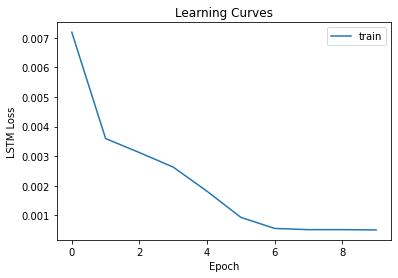

In [30]:
pyplot.title('Learning Curves')
pyplot.xlabel('Epoch')
pyplot.ylabel('LSTM Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.legend()
pyplot.show()

Let us predicit the last days stored on y_test and then we will plot the prediction and the actual values of the positivity rate

In [31]:
X_train[len(X_train)-1]

array([[0.02033891],
       [0.0235102 ],
       [0.020008  ]])

In [32]:
# select the last three days of the data

x_input = np.array([0.10538297,0.0235102,0.10538297])
temp_input=list(x_input)
lst_output=[]
i=0
while(i<10):
    if(len(temp_input)>3):
        x_input=temp_input[1:]
        print("{} day input {}".format(i,x_input))
        #print(x_input)
        x_input = np.reshape(x_input, (1, n_steps, n_features))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat[0][0]))
        print("{} day actual output {}".format(i,y_test[i]))
        print(".............................................")
        temp_input.append(yhat[0][0])
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.append(yhat[0][0])
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps, n_features))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.append(yhat[0][0])
        lst_output.append(yhat[0][0])
        i=i+1
    

# print(lst_output)

[0.07160369]
1 day input [0.0235102, 0.10538297, 0.071603686]
1 day output 0.05209799110889435
1 day actual output 0.021021021021021023
.............................................
2 day input [0.10538297, 0.071603686, 0.05209799]
2 day output 0.07856633514165878
2 day actual output 0.020118157373059335
.............................................
3 day input [0.071603686, 0.05209799, 0.078566335]
3 day output 0.060135021805763245
3 day actual output 0.025679274045287116
.............................................
4 day input [0.05209799, 0.078566335, 0.06013502]
4 day output 0.056131523102521896
4 day actual output 0.02159021766864904
.............................................
5 day input [0.078566335, 0.06013502, 0.056131523]
5 day output 0.0627276822924614
5 day actual output 0.018809659332535148
.............................................
6 day input [0.06013502, 0.056131523, 0.06272768]
6 day output 0.05368893966078758
6 day actual output 0.026156099602427287
............